In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [67]:
import wave
import struct
import librosa
import librosa.display
import IPython
from scipy.io.wavfile import write
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 課題2 5.1chサラウンド信号のステレオ化
与えられたステレオ信号をステレオ(2ch)化せよ．  
出力するステレオ信号L_o，R_oは下記式を用いて算出すること．
$$ L_o = (L + 0.5*C + 0.5*L_s) / 2.0 $$
$$ R_o = (R + 0.5*C + 0.5*R_s) / 2.0 $$
また，作成されたLo側の信号の中央1,000サンプル分を用いてパワースペクトルを計算し，グラフ表示せよ．

In [8]:
def save_wav(path, data, mono=True):
    """
    wav形式のデータを保存する関数．
    
    Parameters
    ----------
    path : str
        保存先へのパス
    data : ndarray
        信号の配列
    """
    if mono:
        channels = 1  # mono
    else:
        channels = 2  # stereo
        
    binwave = struct.pack('h' * len(data), *data)  # バイナリ化

    with wave.Wave_write(path) as wav:
        # チャンネル数(1:モノラル,2:ステレオ)，サンプルサイズ(バイト)，サンプリング周波数，フレーム数
        params = (channels, 2, 16000, len(binwave), 'NONE', 'not compressed')
        wav.setparams(params)
        wav.writeframes(binwave)

In [5]:
# バイナリ形式で開く
with open('./P_file/surround_5.1.raw', 'rb') as raw:
    # h:C言語でのshort型，<:リトルエンディアンで読み込む
    raw_data = np.fromfile(raw, dtype='<h', sep='')
print(raw_data[:13])

[ 2493  -603  2480  2480  2579  1402  3220 -1060  3129  3129  3138  1416
  3949]


In [6]:
# L(左前)，C(中央)，R(右前)，LS(左後)，RS(右後)，LFE(スーパーウーファ)
# 上記の全6ch分のデータが格納されているので，それぞれに分ける
left = raw_data[::6]
center = raw_data[1::6]
right = raw_data[2::6]
left_back = raw_data[3::6]
right_back = raw_data[4::6]
woofer = raw_data[5::6]

In [83]:
# 該当式によるステレオ信号を作成
L_o = ((left + 0.5 * center + 0.5 * left_back) / 2.0).astype(np.int16)
R_o = ((right + 0.5 * center + 0.5 * right_back) / 2.0).astype(np.int16)
mixture = np.concatenate([L_o.reshape(-1, 1), R_o.reshape(-1, 1)], axis=1)  # mixしたステレオ音源

# print(L_o[:5])
# print(R_o[:5])
# print(mixture[:5])

save_wav('./P_file/surround_Lo.wav', L_o)
save_wav('./P_file/surround_Ro.wav', R_o)
write('./P_file/surround_mix.wav', 16000, mixture)

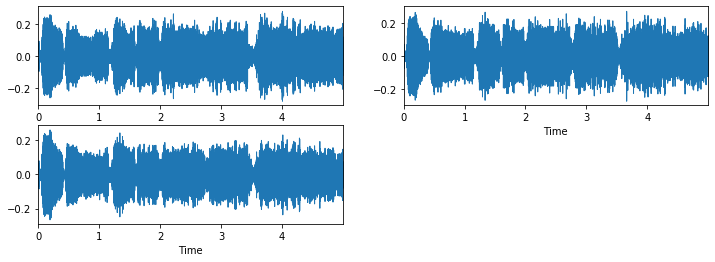

In [84]:
l_x, l_sr = librosa.load('./P_File/surround_Lo.wav')   # 左側チャネル
r_x, r_sr = librosa.load('./P_File/surround_Ro.wav')   # 右側チャネル
m_x, m_sr = librosa.load('./P_file/surround_mix.wav')  # ステレオ音源

plt.figure(figsize=(12, 4))
plt.subplot(221)
librosa.display.waveplot(l_x, sr=l_sr)
plt.subplot(222)
librosa.display.waveplot(r_x, sr=r_sr)
plt.subplot(223)
librosa.display.waveplot(m_x, sr=m_sr)

plt.show()
IPython.display.Audio(data=l_x, rate=l_sr)  # 左音源

In [71]:
IPython.display.Audio(data=r_x, rate=r_sr)  # 右音源

In [85]:
IPython.display.Audio(data=m_x, rate=m_sr)  # ステレオ音源

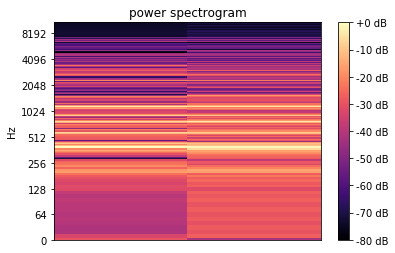

In [47]:
# Librosaで読み込んでスペクトログラムを表示
y, sr = librosa.load('./P_file/surround_Lo.wav')
y_cut = y[int(y.shape[0] / 2 - 500) : int(y.shape[0] / 2 + 500)]  # 中央1000サンプルのみ抽出
l_stft = librosa.stft(y_cut)  # 短時間フーリエ変換
librosa.display.specshow(librosa.amplitude_to_db(np.abs(l_stft), ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('power spectrogram')
plt.show()

IPython.display.Audio(data=y_cut, rate=sr)  # 該当箇所の音